## Cutting-edge Signature-Based Personality Prediction: Pioneering CNN and PCA Methods for Graphological Feature Extraction

In [1]:
import cv2
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout,BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.decomposition import PCA

In [16]:
# Path to the directory containing the data
data_dir = r"C:\Users\sagar\OneDrive\Desktop\Study Material\Applied Data Science Python\Data\latest Data"

# Initialize counters for total images and images per label
total_images = 0
label_counts = {}

# Iterate over the directories in the data directory
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    
    # Count the number of files (images) in each label directory
    if os.path.isdir(label_dir):
        num_images = len(os.listdir(label_dir))
        label_counts[label] = num_images
        
        # Add to the total count
        total_images += num_images

# Print total number of images
print("Total number of images:", total_images)

# Print number of images per label
print("\nNumber of images per label:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

Total number of images: 2388

Number of images per label:
Optimistic: 795
Pessimistic: 794
Realistic: 799


In [2]:
# --- Data Preprocessing ---

baseDirectory = r"C:\Users\sagar\OneDrive\Desktop\Study Material\Applied Data Science Python\Data\latest Data" # File path to my dataset

# This function reads an image from a given path, converts it to grayscale, denoising it using Gaussian Blur, appling Otsu's thresholding to create a binary image, resizing the image to a specified size, converting it back to RGB, and normalizing the pixel values. This sequence of operations prepares the image for machine learning or computer vision tasks by standardizing its size and format and reducing noise.

def preprocess_image(image_path, output_size=(256, 256)):
    
    image = cv2.imread(image_path) # Reading an image from the file path using OpenCV. The image is loaded into the variable image
    if image is None: # The if statement checks if the image is successfully read. If not (image is None), it raises a ValueError indicating the image path might be incorrect or the file is not an image.
        raise ValueError("Could not read the image. Check the image path.")

    # Converting the loaded image from the BGR color space (default in OpenCV) to grayscale. This is often done to reduce computational complexity and focus on the intensity information.
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Applying Gaussian Blur to the grayscale image to reduce noise. The kernel size is set to 5x5 and the standard deviation in the X and Y directions is set to 0, which means it is calculated from the kernel size.
    denoised_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Applying Otsu's thresholding after Gaussian filtering. This automatically determines the best threshold value to convert the image into a binary image (black and white). The pixel values are set to 255 (white) for all pixels above the threshold and 0 (black) for all pixels below.
    _, thresholded_image = cv2.threshold(denoised_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Resizing the thresholded image to a specified size (output_size), which is important for maintaining a consistent input size for machine learning models.
    resized_image = cv2.resize(thresholded_image, output_size)
    
    # Converting the resized image back to the RGB color space. This might be necessary if the subsequent processing or model expects a three-channel input.
    rgb_image = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB)

    # Normalizing the RGB image by scaling pixel values to the range [0, 1]. This is a common preprocessing step before feeding the image into a neural network.
    normalized_image = rgb_image / 255.0

    return normalized_image

In [3]:
# This chunck of code effectively creates a dataset of preprocessed images and their corresponding labels, ready to be fed into a machine learning model for training or evaluation.

preprocessed_images, labels = [], [] # Initializing two empty lists, preprocessed_images for storing the preprocessed images and labels for storing the corresponding labels.
label_mapping = {'optimistic': 0, 'pessimistic': 1, 'realistic': 2} # label_mapping = {'optimistic': 0, 'pessimistic': 1, 'realistic': 2}: Defining a dictionary that maps textual labels ('optimistic', 'pessimistic', 'realistic') to numerical values (0, 1, 2). This is common in machine learning where labels are encoded as integers.
for label_folder, label in label_mapping.items(): # The for loop iterates over the label_mapping dictionary. label_folder receives the key (the textual label), and label receives the value (the numerical label).
    folder_path = os.path.join(baseDirectory, label_folder) # Constructing the path to the directory containing images for the current label by joining the baseDirectory path with the label_folder name.
    for image_name in os.listdir(folder_path): # Another for loop iterates over the names of the files in the folder_path. os.listdir(folder_path) lists all entries in that directory.
        image_path = os.path.join(folder_path, image_name) # For each file in the directory, this constructs the full path to the file by combining the folder path and the file name.
        if os.path.isfile(image_path): # Checks if the path indeed points to a file (and not, for example, to another directory). This is important to avoid trying to process directories as if they were images.
            preprocessed_images.append(preprocess_image(image_path)) #  Calling the previously described preprocess_image function with the current image path, preprocesses the image, and appends the result to the preprocessed_images list.
            labels.append(label) # Appending the current numerical label to the labels list. This associates each preprocessed image with its corresponding label.
preprocessed_images = np.array(preprocessed_images, dtype='float32') # Converting the list of preprocessed images into a NumPy array with datatype float32. This is a common practice in machine learning to facilitate batch processing and computation efficiency.
labels = np.array(labels) # Similarly, converting the list of labels into a NumPy array. This makes it easier to work with machine learning frameworks which typically expect input data in the form of NumPy arrays or tensors.

In [4]:
# --- Model Definition ---
 
# This model architecture, with its multiple convolutional and dense layers, is well-suited for classifying images into one of three categories. The use of max pooling and dropout layers helps in reducing overfitting and makes the model more generalizable.
n_classes = 3  # Specifing the number of classes in the classification task. In this case, there are three classes, which could correspond to the 'optimistic', 'pessimistic', and 'realistic' labels mentioned earlier.
model = Sequential([ #  Initializing a sequential model. In Keras, a Sequential model is a linear stack of layers where each layer has exactly one input tensor and one output tensor.
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),  # Adding the first convolutional layer with 32 filters of size 3x3, using the ReLU activation function. The input_shape=(256, 256, 3) argument specifies the shape of the input images, which are 256x256 pixels in size with 3 channels (RGB).
    MaxPooling2D(pool_size=(2, 2)), # Appling a max pooling operation with a 2x2 window, reducing the spatial dimensions (height and width) of the input by half.
    BatchNormalization(),
    # Two more convolutional layers are added, each followed by a max pooling layer. The number of filters in the convolutional layers increases with depth (64 and then 128), allowing the network to capture more complex features.
    Conv2D(64, (3, 3), activation='relu'),  
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(), # Flattening the 3D output of the last pooling layer into a 1D tensor, making it possible to connect to a fully connected (Dense) layer.
    Dense(128, activation='relu'),  # Adding a fully connected layer with 128 units and ReLU activation function. The size of this layer is increased compared to typical models to handle more complex features extracted from the larger input images.
    Dropout(0.5), #  Appling dropout with a rate of 0.5 to the output of the previous layer, randomly setting half of the input units to 0 at each update during training time. This helps prevent overfitting.
    # Another dense layer with 64 units and ReLU activation is added, followed by another dropout layer. This configuration adds additional capacity and regularization to the model.
    Dense(64, activation='relu'),
    Dropout(0.5),
    # The final layer is a fully connected layer with a number of units equal to the number of classes (3 in this case) and uses the softmax activation function. This layer outputs a probability distribution over the three classes.
    Dense(n_classes, activation='softmax')
])

# Configures the model for training. The optimizer used is 'adam', a popular choice for deep learning models. The loss function is 'categorical_crossentropy', appropriate for multi-class classification tasks. The metric used to evaluate the model's performance during training and testing is 'accuracy'.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 127, 127, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                     

In [5]:
# --- Preparing Data for Training ---
X_train, X_val, y_train, y_val = train_test_split(preprocessed_images, labels, test_size=0.2, random_state=42) #Using the train_test_split function from the sklearn.model_selection module to split the preprocessed images and their corresponding labels into training and validation sets. The test_size=0.2 argument specifies that 20% of the data will be reserved for the validation set, while the remaining 80% will be used for training. The random_state=42 argument ensures reproducibility by setting a seed for the random number generator used in the splitting process.
y_train_categorical = to_categorical(y_train, num_classes=n_classes) # Converting the training labels, which are currently in integer form, into a binary class matrix using the to_categorical function. This is necessary because the CNN model's output layer uses a softmax activation function, which expects labels to be in a one-hot encoded format. For example, if y_train contains a label 2 and there are three classes, it would be converted to [0, 0, 1]. The num_classes=n_classes argument specifies the total number of classes, ensuring that the one-hot encoded vectors are of the correct length.
y_val_categorical = to_categorical(y_val, num_classes=n_classes) #  Similaring to the training labels, this line converts the validation labels into a binary class matrix using the same to_categorical function and num_classes parameter. This ensures that the validation labels are also in the one-hot encoded format, suitable for evaluation with the CNN model.

In [6]:
# --- Model Training ---
cbs = [
    EarlyStopping(patience=3, restore_best_weights=True)
]
# The .fit() method trains the model for a fixed number of epochs (iterations over the entire dataset). It returns a History object that contains a record of training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values.
# X_train, y_train_categorical: These are the training data and their corresponding one-hot encoded labels. The model will learn from this data.
# validation_data=(X_val, y_val_categorical): This tuple specifies the validation data and its corresponding one-hot encoded labels. The model will not learn from this data; instead, it will evaluate its performance on this data at the end of each epoch, providing insight into how well it generalizes to unseen data.
# epochs=100: This specifies the number of times the learning algorithm will work through the entire training dataset. Here, the model will go through the X_train and y_train_categorical data 100 times.
# batch_size=32: This defines the number of samples that will be propagated through the network at one time. Smaller batch sizes require less memory and can lead to better training dynamics
history = model.fit(X_train, y_train_categorical, validation_data=(X_val, y_val_categorical), epochs=100,callbacks=cbs, batch_size=32) 

Epoch 1/100


60/60 [==============================] - 33s 531ms/step - loss: 1.2534 - accuracy: 0.6832 - val_loss: 0.9172 - val_accuracy: 0.7908
Epoch 2/100
60/60 [==============================] - 32s 537ms/step - loss: 0.3447 - accuracy: 0.8712 - val_loss: 0.7704 - val_accuracy: 0.8452
Epoch 3/100
60/60 [==============================] - 32s 540ms/step - loss: 0.2675 - accuracy: 0.9031 - val_loss: 0.6675 - val_accuracy: 0.9038
Epoch 4/100
60/60 [==============================] - 32s 533ms/step - loss: 0.2055 - accuracy: 0.9304 - val_loss: 0.3199 - val_accuracy: 0.9226
Epoch 5/100
60/60 [==============================] - 32s 533ms/step - loss: 0.1515 - accuracy: 0.9503 - val_loss: 0.2843 - val_accuracy: 0.9142
Epoch 6/100
60/60 [==============================] - 33s 545ms/step - loss: 0.1005 - accuracy: 0.9660 - val_loss: 0.1986 - val_accuracy: 0.9100
Epoch 7/100
60/60 [==============================] - 33s 548ms/step - loss: 0.1178 - accuracy: 0.9597 - val_loss: 0.2720 - val_accurac

In [7]:
# Flatten the image data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=100)  # You can adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train_flat)
X_val_pca = pca.transform(X_val_flat)

# Reshape the PCA-transformed data back to the original shape (assuming 256x256 images)
# Reshape into 4D tensor for convolutional layers
X_train_pca_reshaped = X_train_pca.reshape(X_train.shape[0], 10, 10, 1)  
X_val_pca_reshaped = X_val_pca.reshape(X_val.shape[0], 10, 10, 1)  

# Define the number of classes
n_classes = 3

# Initialize a new sequential model
modelPca = Sequential()

# Add layers to the model
modelPca.add(Conv2D(32, (3, 3), activation='relu', input_shape=(10, 10, 1)))  # Adjusted input shape for PCA
modelPca.add(MaxPooling2D(pool_size=(2, 2)))
modelPca.add(BatchNormalization())
modelPca.add(Conv2D(64, (3, 3), activation='relu'))
modelPca.add(MaxPooling2D(pool_size=(2, 2)))
modelPca.add(Flatten())
modelPca.add(Dense(128, activation='relu'))
modelPca.add(Dropout(0.5))
modelPca.add(Dense(64, activation='relu'))
modelPca.add(Dropout(0.5))
modelPca.add(Dense(n_classes, activation='softmax'))

# Compile the model
modelPca.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
modelPca.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 8, 8, 32)          320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 4, 4, 32)          0         
 g2D)                                                            
                                                                 
 batch_normalization_1 (Bat  (None, 4, 4, 32)          128       
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 2, 2, 64)          18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 1, 1, 64)          0         
 g2D)                                                            
                                                      

In [8]:
# Train the model
historyPCA = modelPca.fit(X_train_pca_reshaped, y_train_categorical, epochs=100,callbacks=cbs, batch_size=32, validation_data=(X_val_pca_reshaped, y_val_categorical))

Epoch 1/100
60/60 [==============================] - 2s 12ms/step - loss: 0.9887 - accuracy: 0.5257 - val_loss: 1.1057 - val_accuracy: 0.3870
Epoch 2/100
60/60 [==============================] - 0s 5ms/step - loss: 0.7691 - accuracy: 0.6607 - val_loss: 0.7251 - val_accuracy: 0.7176
Epoch 3/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6155 - accuracy: 0.7482 - val_loss: 0.4260 - val_accuracy: 0.8431
Epoch 4/100
60/60 [==============================] - 0s 4ms/step - loss: 0.4608 - accuracy: 0.8209 - val_loss: 0.3453 - val_accuracy: 0.8745
Epoch 5/100
60/60 [==============================] - 0s 3ms/step - loss: 0.3994 - accuracy: 0.8429 - val_loss: 0.3302 - val_accuracy: 0.8828
Epoch 6/100
60/60 [==============================] - 0s 5ms/step - loss: 0.3083 - accuracy: 0.8775 - val_loss: 0.3593 - val_accuracy: 0.8640
Epoch 7/100
60/60 [==============================] - 0s 4ms/step - loss: 0.2619 - accuracy: 0.8995 - val_loss: 0.3285 - val_accuracy: 0.8640
Epoch 8/100


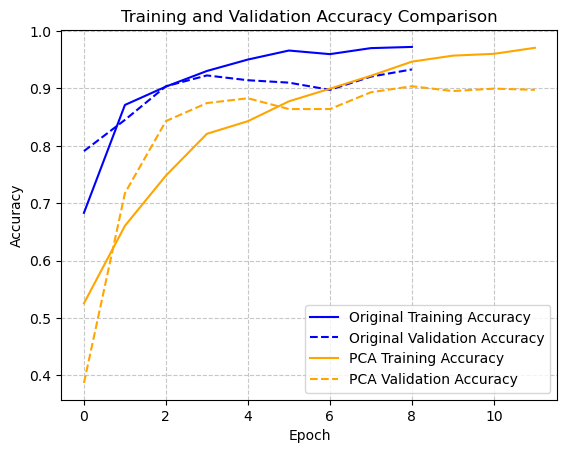

In [9]:
# Plotting the accuracy histories of the original and PCA models
plt.plot(history.history['accuracy'], label='Original Training Accuracy', color='blue', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Original Validation Accuracy', color='blue', linestyle='--')
plt.plot(historyPCA.history['accuracy'], label='PCA Training Accuracy', color='orange', linestyle='-')
plt.plot(historyPCA.history['val_accuracy'], label='PCA Validation Accuracy', color='orange', linestyle='--')

# Title and labels
plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Legend and location
plt.legend(loc='lower right')

# Show plot
plt.show()

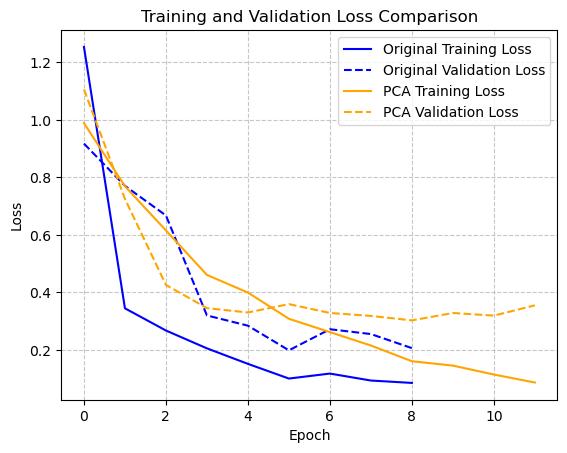

In [10]:
# Plotting the loss histories of the original and PCA models
plt.plot(history.history['loss'], label='Original Training Loss', color='blue', linestyle='-')
plt.plot(history.history['val_loss'], label='Original Validation Loss', color='blue', linestyle='--')
plt.plot(historyPCA.history['loss'], label='PCA Training Loss', color='orange', linestyle='-')
plt.plot(historyPCA.history['val_loss'], label='PCA Validation Loss', color='orange', linestyle='--')

# Title and labels
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Legend and location
plt.legend(loc='upper right')

# Show plot
plt.show()

15/15 [==============================] - 0s 3ms/step
Original Model Validation Accuracy: 0.9100
PCA Model Validation Accuracy: 0.9038


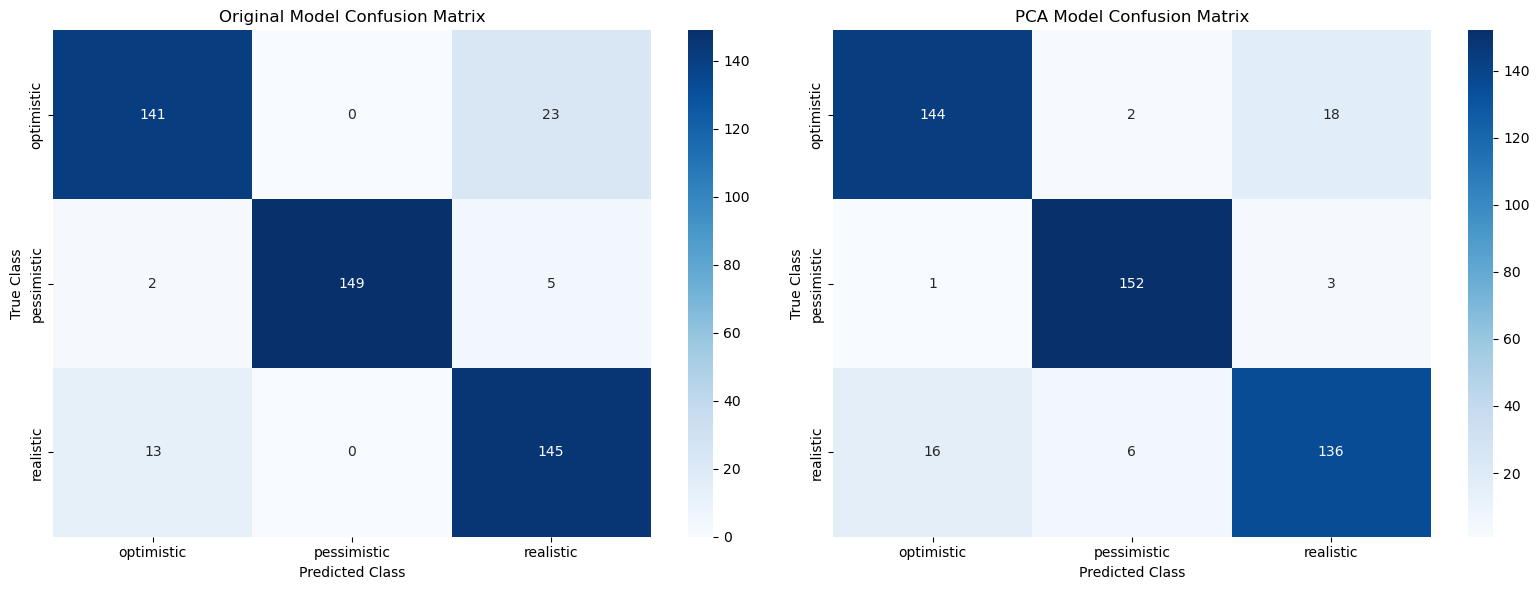

In [11]:
# Compute predictions for the original model on the validation set
val_predictions_prob = model.predict(X_val)
val_predicted_classes = np.argmax(val_predictions_prob, axis=1)

# Make predictions on the validation set for the PCA model
val_predictions_prob_pca = modelPca.predict(X_val_pca_reshaped)
val_predicted_classes_pca = np.argmax(val_predictions_prob_pca, axis=1)

# Convert one-hot encoded validation labels back to class indices for comparison
val_true_classes = np.argmax(y_val_categorical, axis=1)

# Calculate the accuracy for both models
val_accuracy_original = accuracy_score(val_true_classes, val_predicted_classes)
val_accuracy_pca = accuracy_score(val_true_classes, val_predicted_classes_pca)

print(f'Original Model Validation Accuracy: {val_accuracy_original:.4f}')
print(f'PCA Model Validation Accuracy: {val_accuracy_pca:.4f}')

# Plot the confusion matrices for both models side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Original Model Confusion Matrix
conf_matrix_original = confusion_matrix(val_true_classes, val_predicted_classes)
sns.heatmap(conf_matrix_original, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()), ax=axes[0])
axes[0].set_title('Original Model Confusion Matrix')
axes[0].set_ylabel('True Class')
axes[0].set_xlabel('Predicted Class')

# PCA Model Confusion Matrix
conf_matrix_pca = confusion_matrix(val_true_classes, val_predicted_classes_pca)
sns.heatmap(conf_matrix_pca, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()), ax=axes[1])
axes[1].set_title('PCA Model Confusion Matrix')
axes[1].set_ylabel('True Class')
axes[1].set_xlabel('Predicted Class')

plt.tight_layout()
plt.show()

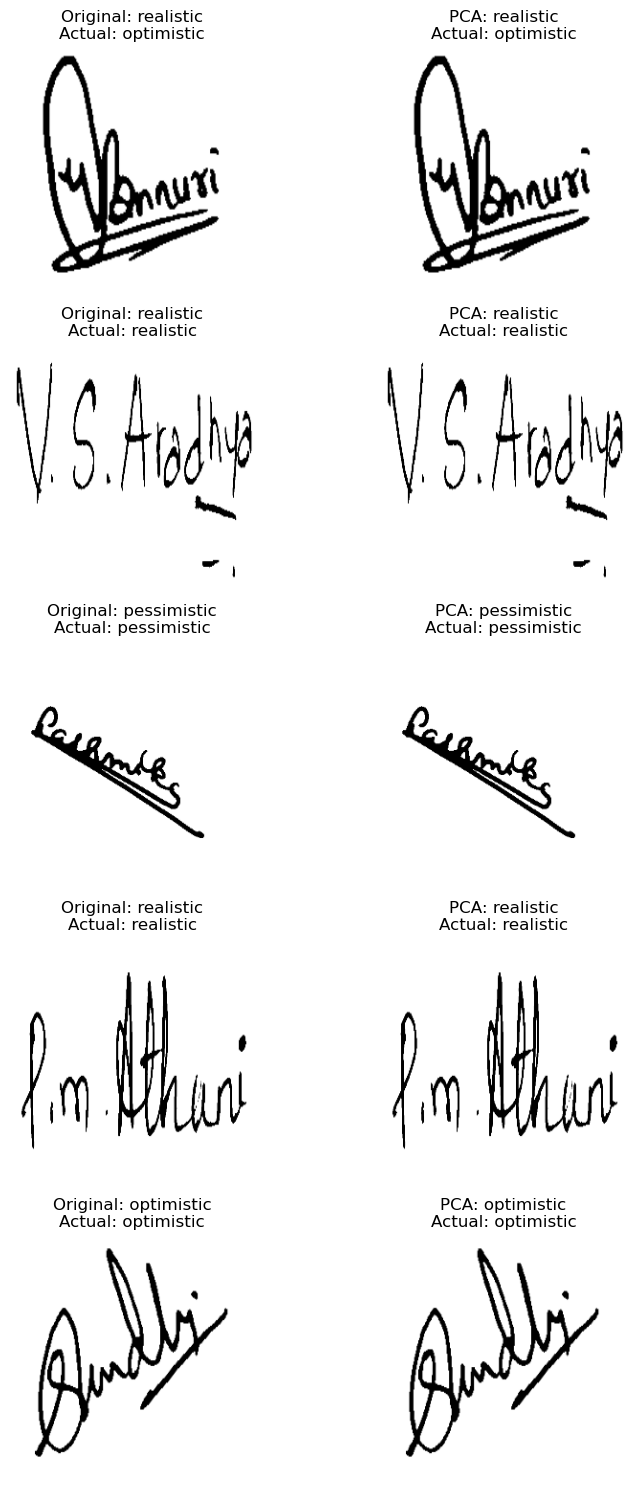

In [12]:
def display_images_with_predictions_comparison(X_data, true_labels, predicted_labels_original, predicted_labels_pca, label_mapping, number_of_images_per_model=5):
    # Reverse the label mapping to get label names from indices
    reversed_label_mapping = {v: k for k, v in label_mapping.items()}
    
    # Set up the subplot grid
    fig, axes = plt.subplots(number_of_images_per_model, 4, figsize=(15, 3 * number_of_images_per_model))
    
    # Plot images and predictions for the original model
    for i in range(number_of_images_per_model):
        # Plot original model prediction
        axes[i, 0].imshow(X_data[i])
        axes[i, 0].set_title(f"Original: {reversed_label_mapping[predicted_labels_original[i]]}\nActual: {reversed_label_mapping[true_labels[i]]}")
        axes[i, 0].axis('off')

        # Plot PCA model prediction
        axes[i, 1].imshow(X_data[i])
        axes[i, 1].set_title(f"PCA: {reversed_label_mapping[predicted_labels_pca[i]]}\nActual: {reversed_label_mapping[true_labels[i]]}")
        axes[i, 1].axis('off')

        # Remove empty subplot spaces
        for ax in axes[i, 2:]:
            ax.remove()
    
    # Adjust layout for better viewing
    plt.tight_layout()
    plt.show()

# Call the function to display 5 images with predictions for both models side by side
display_images_with_predictions_comparison(X_val, val_true_classes, val_predicted_classes, val_predicted_classes_pca, label_mapping, number_of_images_per_model=5)

1/1 [==============================] - 0s 77ms/step


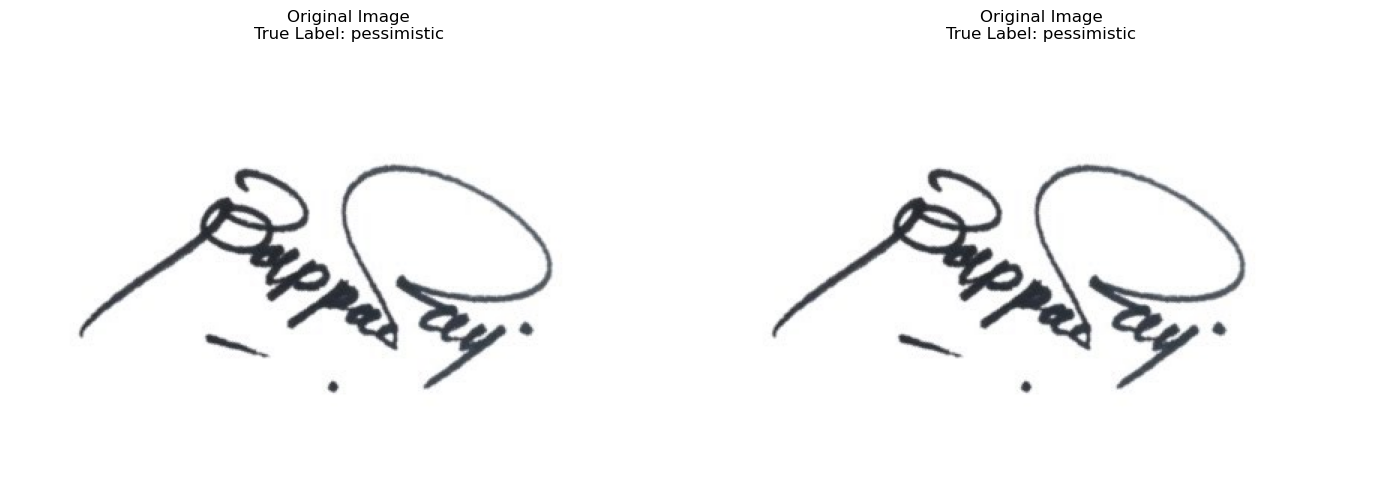

Predicted Label (Model 1 - PCA): pessimistic
Predicted Label (Model 2): pessimistic


In [19]:
import cv2
import matplotlib.pyplot as plt

def preprocess_image_for_pca(image_path, target_size=(10, 10)):
    """
    Preprocesses an image for the PCA model.

    Args:
    - image_path (str): The file path of the image.
    - target_size (tuple): The target size to resize the image.

    Returns:
    - numpy.ndarray: The preprocessed image in the format suitable for the PCA model.
    """
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    normalized_img = gray_img / 255.0
    reshaped_img = normalized_img.reshape(1, *target_size, 1)
    return reshaped_img

def make_prediction_on_single_image(image_path, model, modelPca, label_mapping, true_label):
    # Load and display the original image
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    # Preprocess the image for both models
    preprocessed_image1 = preprocess_image_for_pca(image_path)
    preprocessed_image_batch1 = np.expand_dims(preprocessed_image1, axis=0)  # Add batch dimension
    preprocessed_image2 = preprocess_image(image_path)
    preprocessed_image_batch2 = np.expand_dims(preprocessed_image2, axis=0)  # Add batch dimension

    # Make predictions for both models
    prediction_probabilities1 = modelPca.predict(preprocessed_image_batch1)
    predicted_class_index1 = np.argmax(prediction_probabilities1, axis=1)[0]
    predicted_class_label1 = list(label_mapping.keys())[list(label_mapping.values()).index(predicted_class_index1)]
    
    prediction_probabilities2 = model.predict(preprocessed_image_batch2)
    predicted_class_index2 = np.argmax(prediction_probabilities2, axis=1)[0]
    predicted_class_label2 = list(label_mapping.keys())[list(label_mapping.values()).index(predicted_class_index2)]

    # Display the images and predictions side by side
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image\nTrue Label: {}'.format(true_label))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(original_image)
    plt.title('Original Image\nTrue Label: {}'.format(true_label))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Display the predicted labels for both models
    print('Predicted Label (Model 1 - PCA):', predicted_class_label1)
    print('Predicted Label (Model 2):', predicted_class_label2)

# Example usage:
make_prediction_on_single_image(r"C:\Users\sagar\OneDrive\Desktop\Study Material\Data\new_training\Pessimistic\n1.jpg", model, modelPca, label_mapping, 'pessimistic')